# *Predicting Length of Stay at a Hospital*

Task is to predict Length of Stay (LOS) Category from the below data. Increased importance to accurately patients with higher LOS.

In [1]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical 


train_data=pd.read_csv('/kaggle/input/av-healthcare-analytics-ii/healthcare/train_data.csv')
test_data=pd.read_csv('/kaggle/input/av-healthcare-analytics-ii/healthcare/test_data.csv')

# **Data Exploration**

In [2]:
#  view the dataset's categories at-a-glance
train_data.info()
# test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [3]:
# more details if necessary
# print(train_data.shape)
# print(test_data.shape)
# print(train_data.head())
# print(train_data.dtypes.value_counts())
# print(train_data.describe(include='int').T)
# print(train_data.describe(include='float').T)
# print(train_data.describe(include='object').T)

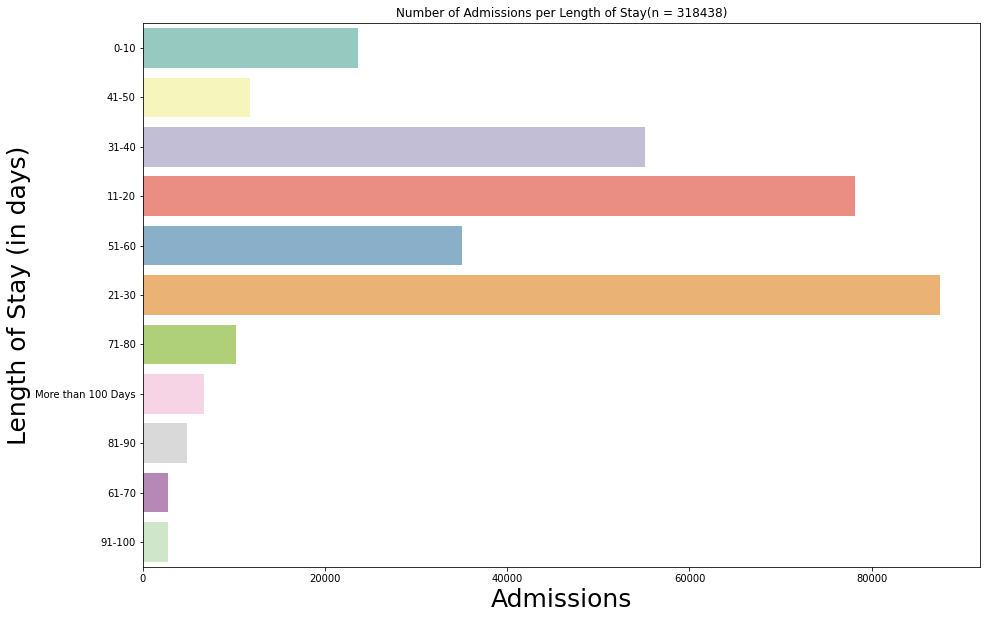

<Figure size 432x288 with 0 Axes>

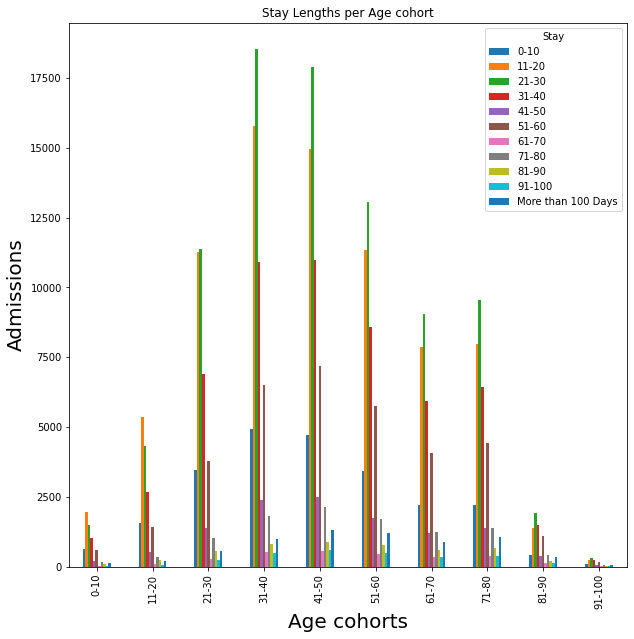

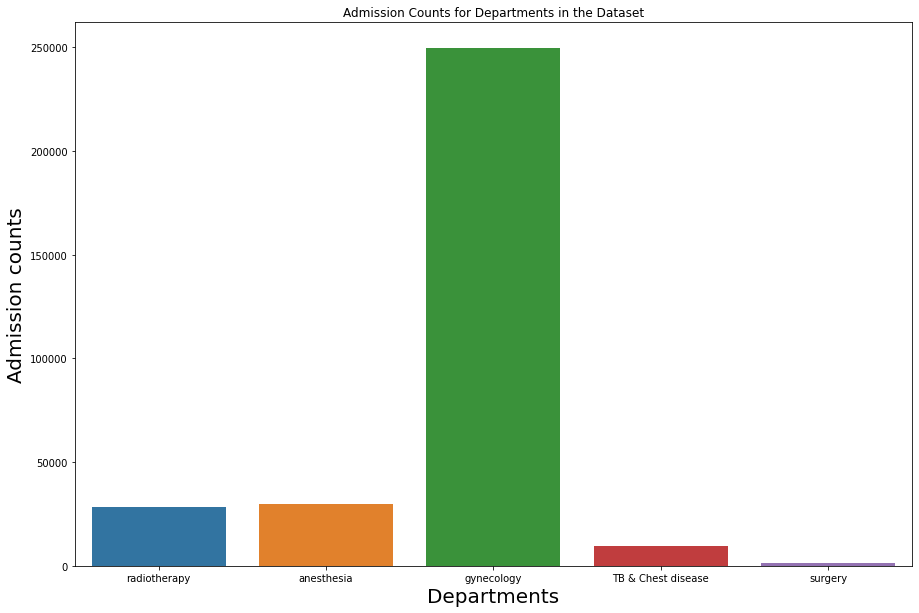

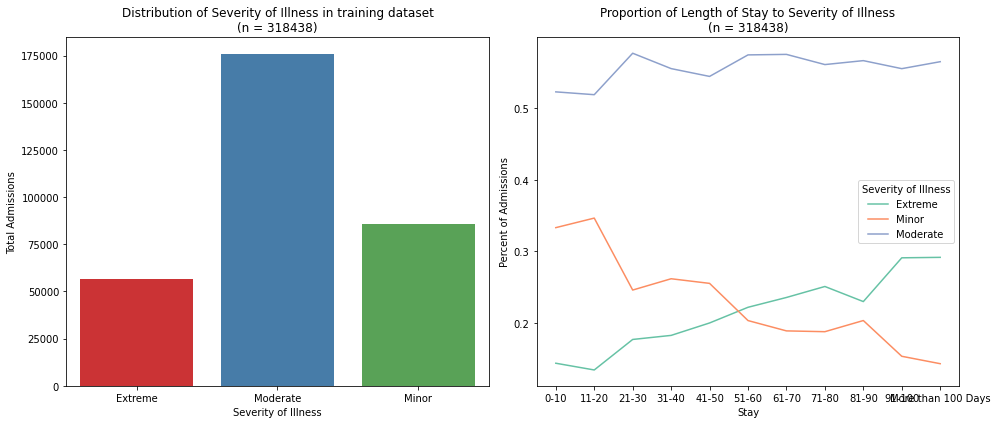

<AxesSubplot:>

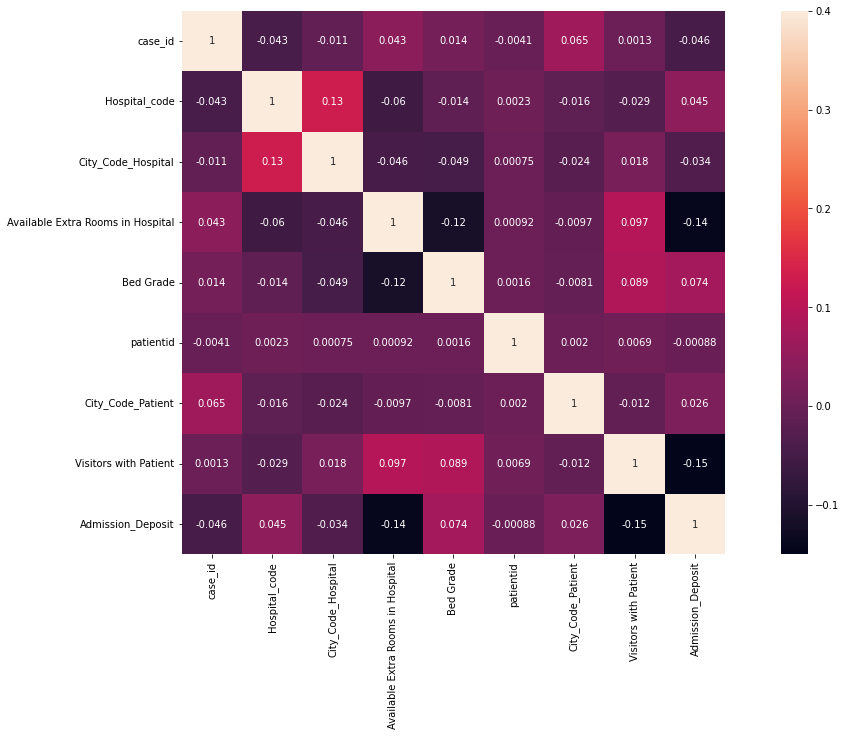

In [4]:
## All Data Visualization code together for convenience

# visualize Length of Stay intervals only
plt.figure(figsize = (15,10))
sns.countplot(y = 'Stay', data = train_data, palette = 'Set3')
plt.xlabel('Admissions', size = 25)
plt.ylabel('Length of Stay (in days)', size = 25)
plt.title('Number of Admissions per Length of Stay(n = {})'.format(len(train_data)))
plt.show()

# visualize distribution of LOS by age cohort
los_indices = train_data.Stay.value_counts().index[:11]
age_indices = train_data.Age.value_counts().index[:10]
cross_data = train_data[train_data.Stay.isin(los_indices)& (train_data.Age.isin(age_indices))]
plt.figure()
cross_table = pd.crosstab(columns= cross_data.Stay, index = cross_data.Age) 
cross_table.plot.bar(figsize = (10,10), title="Stay Lengths per Age cohort")
plt.xlabel('Age cohorts', size = 20)
plt.ylabel('Admissions', size = 20)
plt.show()

# visualize admissions by departments
plt.figure(figsize=(15, 10))
sns.countplot(x = train_data.Department)
plt.title("Admission Counts for Departments in the Dataset")
plt.ylabel('Admission counts', size = 20)
plt.xlabel('Departments', size = 20)

# visualize admissions by illness severity
f, (vis1, vis2) = plt.subplots(1,2, figsize = (14,6))

# +++++++++
sns.countplot(x= train_data["Severity of Illness"], ax = vis1, palette = 'Set1')
vis1.set_title("""Distribution of Severity of Illness in training dataset
(n = {})""".format(len(train_data)))
vis1.set_ylabel("Total Admissions")

# ++++++++++
illness = train_data.groupby(["Severity of Illness", "Stay"]).size()
illness = (illness/illness.groupby(level=1).sum()).reset_index()
# ++++++++++++++++++

sns.lineplot(x = 'Stay', y = 0, hue = "Severity of Illness", data = illness, ax = vis2, palette = 'Set2')
vis2.set_title("""Proportion of Length of Stay to Severity of Illness
(n = {})""".format(len(train_data)))
vis2.set_ylabel("Percent of Admissions")

plt.tight_layout()
plt.show()


# correlation matrix
corr_matrix = train_data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix,vmax=.4, square=True,annot=True)

# **Data Cleaning**

In [5]:
# remove null values
train_data = train_data.dropna()
test_data = test_data.dropna()
# case ids will never help with predicting,so this category is removed;
train_data = train_data.drop(['case_id'], axis = 1)
test_data = test_data.drop(['case_id'], axis = 1)

# folds in repeated patient ids instances  into N number of visits 
train_data['Visits'] = train_data.groupby(['patientid'])['patientid'].transform('count')
train_data = train_data.drop(['patientid'], axis=1) 

test_data['Visits'] = test_data.groupby(['patientid'])['patientid'].transform('count')
test_data = test_data.drop(['patientid'], axis=1) 

# normalize some of the data in columns with high amount of unique values
# academic honesty: inspired by example by JAKE TURICCHI on Kaggle --> see code section for this kaggle dataset
threshold = 0.05
hospital_codes = train_data['Hospital_code'].value_counts(normalize = True)
hospital_codes_below_threshold = hospital_codes.where(hospital_codes < threshold).dropna().index.values
train_data['Hospital_code']= np.where(train_data['Hospital_code'].isin(hospital_codes_below_threshold), '0',  train_data['Hospital_code'])

city_code_patients = train_data['City_Code_Patient'].value_counts(normalize = True)
patient_codes_below_threshold = city_code_patients.where(city_code_patients < threshold).dropna().index.values
train_data['City_Code_Patient']= np.where(train_data['City_Code_Patient'].isin(patient_codes_below_threshold), '0',  train_data['City_Code_Patient'])

# **Encoding**

In [6]:
# prepare columns to ease the encoding of categorical values
target=['Hospital_code', 'City_Code_Hospital',
        'City_Code_Patient', 'Severity of Illness',
        'Hospital_type_code', 'Hospital_region_code', 
        'Department', 'Type of Admission', 'Bed Grade',
        'Ward_Facility_Code',  'Ward_Type', 'Age'] 

# only train data has Stay column
train_data['Stay'] = train_data['Stay'].astype('category')
train_data[target] = train_data[target].astype('category')
test_data[target] = test_data[target].astype('category')


# integer encoding step
def integer_encode_columns(dataframe, column_list):
    encoder = LabelEncoder()
    df = dataframe.copy()
    for column in column_list:
        col_name = column + '_lbl'
        df[col_name] = encoder.fit_transform(df[column])
    
    df = df.drop(column_list, axis = 1)
    df = df.reset_index(drop = True)
    return df


encode_targets = ['Hospital_code','Hospital_type_code','City_Code_Hospital', 
                  'Hospital_region_code','Department','Ward_Type','Ward_Facility_Code',
                  'City_Code_Patient', 'City_Code_Hospital', 'Type of Admission', 
                  'Severity of Illness', 'Age', 'Stay', 'Bed Grade']
encoded_df = integer_encode_columns(train_data, encode_targets)

# binary encode Stay to turn prediction of LOS into a Binary Classification of Short (0-10 days) or Long (More than 10 days)
def binary_encode_column(dataframe, column, inplace = True):
    if inplace:
        dataframe.loc[dataframe[column]!= 0] = 1
        dataframe = dataframe.reset_index(drop = True)
        return
    else:
        df = dataframe.copy()
        df.loc[df[column]!= 0]= 1
        df = df.reset_index(drop = True)
        return df
    
binary_encode_column(encoded_df, 'Stay_lbl')

# use pd.set_option('max_columns', None) in console to allow for viewing of all columns
## rename most columns back to their original names before the _lbl suffix, or to a name following uniform naming convention
encoded_df.rename(columns = {'Hospital_code_lbl':'Hospital_code', 
                             'Hospital_type_code_lbl':'Hospital_type_code',
                             'City_Code_Hospital_lbl':'City_Code_Hospital',
                            'Hospital_region_code_lbl':'Hospital_region_code',
                            'Department_lbl': 'Department',
                             'Ward_Type_lbl': 'Ward_Type',
                            'Ward_Facility_Code_lbl': 'Ward_Facility_Code', 
                            'City_Code_Patient_lbl': 'City_Code_Patient',
                            'City_Code_Hospital_lbl': 'City_Code_Hospital',
                            'Type of Admission_lbl': 'Admission_Type',
                            'Severity of Illness_lbl': 'Illness_Severity',
                            'Age_lbl': 'Age', 'Stay_lbl': 'Stay', 
                            'Bed Grade_lbl': 'Bed_Grade'}, inplace = True)

In [7]:
numpy_train_data = encoded_df.to_numpy()
numpy_train_labels =  encoded_df.values
print(type(train_data))
print(type(numpy_train_data))
print(type(numpy_train_labels))
print(numpy_train_data.shape)
print(numpy_train_labels.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(313793, 17)
(313793, 17)


In [8]:
#scaler = StandardScaler()
#alread_numeric_columns=['Available Extra Rooms in Hospital', 'Visitors with Patient',
#              'Admission_Deposit', 'Visits']

#for column in train_data[alread_numeric_columns].columns:
#   train_data[column] = scaler.fit_transform(train_data[[column]])

input_features = ["Illness_Severity", "Age", "Admission_Type",
                  "Hospital_code", "Department", "Visitors with Patient"]

# y = independent variable, X = dependent variable(s)
y_feature = "Stay"
X_train = encoded_df.loc[:, input_features + [y_feature]]
#X_train = train_data.loc[:, input_features + [y_feature]]

ordered_categories = input_features[0:2]
unordered_categories = input_features[2:-1]
num = [input_features[-1]]




In [9]:
def prepare_dataset():

    # Convert categorical variables to indices
    X_trn = None
    m = MinMaxScaler()

    for column in X_train.columns:
        #print(column)
        if column in unordered_categories or column in ordered_categories or column == y_feature:
            _ = pd.factorize(X_train[column], sort=True)[0]
            if column in unordered_categories:
                _ = to_categorical(_, num_classes=X_train[column].unique().size)
            elif column in ordered_categories:
                _ = _/np.max(_)
        else:
            #print(column)
            _ = m.fit_transform(X_train[column].values.reshape(-1,1))[:, 0]

        try:
            print("Xtrn: ", X_trn.shape) 
        except:
            pass
        print("_: ",_.shape)
        
        try:
            if len(_.shape) == 1:
                    print("1D")
                    X_trn = np.hstack((X_trn, _.reshape(-1,1)))
            else:
                X_trn = np.hstack((X_trn, _))  
        except Exception as e:
            print("Error: We are up a creek without a paddle or Cheetohs")
            if len(_.shape) == 1:
                    print("1D")
                    X_trn = _.reshape(-1,1)
            else:
                X_trn = _

    X_trn = X_trn
    y_trn = X_trn[:, -1]
#     print(y_trn)
    X_trn = X_trn[:, :-1]
#     print(X_trn)

    # adding Visitors Number ^ 2 to add another feature
    #X_trn = np.vstack((X_trn.T, m.fit_transform(((X_train["Visitors with Patient"]**2).values).reshape(-1,1))[:, 0])).T
    #print(X_trn.shape)
    
    y_trn = to_categorical(y_trn, num_classes=train_data.Stay.unique().size)
#     print(y_trn)
    X_trn, X_val, y_trn, y_val = train_test_split(X_trn, y_trn, test_size=0.3)
    
    return X_trn, X_val, y_trn, y_val

In [10]:
X_train, X_test, y_train,y_test  = prepare_dataset()
print(X_train)
# print(y_train)
# train_data.Stay.unique().size

_:  (313793,)
1D
Error: We are up a creek without a paddle or Cheetohs
1D
Xtrn:  (313793, 1)
_:  (313793,)
1D
Xtrn:  (313793, 2)
_:  (313793, 3)
Xtrn:  (313793, 5)
_:  (313793, 8)
Xtrn:  (313793, 13)
_:  (313793, 5)
Xtrn:  (313793, 18)
_:  (313793,)
1D
Xtrn:  (313793, 19)
_:  (313793,)
1D
[[0.5        0.11111111 0.         ... 0.         0.         0.        ]
 [0.5        0.11111111 0.         ... 0.         0.         0.        ]
 [0.5        0.11111111 0.         ... 0.         0.         0.        ]
 ...
 [0.5        0.11111111 0.         ... 0.         0.         0.        ]
 [0.5        0.11111111 0.         ... 0.         0.         0.        ]
 [0.5        0.11111111 0.         ... 0.         0.         0.        ]]


# **Training the Neural Network**

In [11]:
# define model to tackle this single-label, binary classification problem
model = Sequential()
model.add(Dense(128, input_dim = X_train.shape[1] , activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(11, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1419      
Total params: 53,515
Trainable params: 53,515
Non-trainable params: 0
_________________________________________________________________



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [12]:

X_train=np.asarray(X_train).astype(np.int)
y_train=np.asarray(y_train).astype(np.int)
model.fit(X_train,y_train,validation_split = 0.2, batch_size = 225, epochs = 5, shuffle = True, verbose = 2)

# _, accuracy = model_base.evaluate(x_train, y_test, verbose=0)
# print('Accuracy: %.2f' % (accuracy*100))
# monitor = EarlyStopping(monitor = '??', min_delta = ?)
# checkpointer = ModelCheckPoint(filepath = 'DIR', verbose = 0, save_best_only= True)

2021-12-07 15:37:11.991219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
781/781 - 4s - loss: 0.0165 - accuracy: 0.9972 - val_loss: 5.5124e-04 - val_accuracy: 1.0000
Epoch 2/5
781/781 - 3s - loss: 9.7124e-04 - accuracy: 0.9999 - val_loss: 7.6415e-04 - val_accuracy: 1.0000
Epoch 3/5
781/781 - 4s - loss: 0.0010 - accuracy: 0.9999 - val_loss: 6.2107e-04 - val_accuracy: 1.0000
Epoch 4/5
781/781 - 3s - loss: 0.0011 - accuracy: 0.9999 - val_loss: 5.4092e-04 - val_accuracy: 1.0000
Epoch 5/5
781/781 - 3s - loss: 9.9979e-04 - accuracy: 0.9999 - val_loss: 5.0274e-04 - val_accuracy: 1.0000


In [13]:
# create confusion matrix
# academic honesty: code to be taken from scikit learn's website